# Solving Two-point Boundary Value Problems

In [1]:
from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In the context of optimal control and trajectory optimization, the necessary optimality conditions for infinite-dimensional optimal control problems take the form of a two-point boundary value problem (TPBVP).
These problems consist of a set of $2n$ differential equations along with boundary conditions at both initial and end times, $t_0$ and $t_f$, where $n$ is the dimension of the state space of the dynamical system.

We can use the `solve_bvp` method from the SciPy library to solve these types of problems numerically.

## Solving a simple TPBVP with SciPy

Consider a simple example where our dynamical system has the dynamics:
\begin{equation}
\dot{z}_1 = z_2, \quad \dot{z}_2 = -z_1.
\end{equation}
and we have the boundary conditions $z_1(t_0) = 0$ and $z_1(t_f) = -2$.

We can use `scipy.integrate.solve_bvp` to solve this problem using the code below:

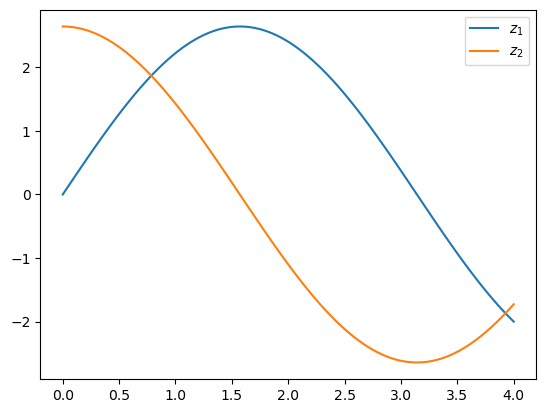

In [2]:
def g(t, z):
    # Dynamics ż = g(z,t)
    return np.vstack((z[1], -z[0]))

def l(z0, zf):
    # Boundary conditions in standard form: l(z0, zf) = 0
    return np.array([z0[0], zf[0] + 2])

# Time mesh and initial guess for z(t)
t_mesh = np.linspace(0, 4, 5)
z_guess = np.zeros((2, t_mesh.size))

# Solve TPBVP using solve_bvp from SciPy
sol = solve_bvp(g, l, t_mesh, z_guess)

# Plot solution
t_plot = np.linspace(0, 4, 100)
z_plot = sol.sol(t_plot)
plt.plot(t_plot, z_plot[0], label=r"$z_1$")
plt.plot(t_plot, z_plot[1], label=r"$z_2$")
plt.legend()
plt.show()